_NOTE: for some unknown reasons, the code would not run when we ask the model to predict and return yhat._

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def gen_data(m, seed=1, scale=0.7):
    """ generate a data set based on a x^2 with added noise """
    c = 0
    x_train = np.linspace(0,49,m)
    np.random.seed(seed)
    y_ideal = x_train**2 + c
    y_train = y_ideal + scale * y_ideal*(np.random.sample((m,))-0.5)
    x_ideal = x_train #for redraw when new data included in X
    return x_train, y_train, x_ideal, y_ideal

### Prepare and visualise the dataset
Applying what we've learnt -- splitting into training and testing sets

X shape:  (18,)  y shape:  (18,)


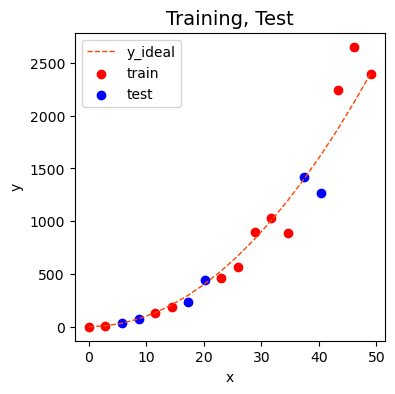

In [6]:
X, y, x_ideal, y_ideal = gen_data(18, 2, 0.7)
print("X shape: ", X.shape, " y shape: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# 18 samples are split into 12 training and 6 test samples

fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red", label="train")
ax.scatter(X_test, y_test, color = "blue", label="test")
ax.legend(loc='upper left')
plt.show()

In [7]:
# Evaluate the error on the data set for a linear regression model

def eval_model(y, yhat):
    m = len(y)
    J_test = 0
    for i in range(m):
        J_test += (y[i] - yhat[i]) ** 2
    return J_test/(2*m)

### Let's build a linear regression model using tools from Scikit-learn!
It is very important to THOROUGHLY understand the following code as we have never implemented a linear regression model with polynomial features and regularization before in Scikit Learn. 

In [12]:
class lin_model: # customized model from LinearRegression()
    def __init__(self, degree, regularization=False, lambda_=0):
        if regularization:
            self.model = Ridge(alpha=lambda_)
        else:
            self.model = LinearRegression()
        self.poly = PolynomialFeatures(degree, include_bias = False)
        self.scaler = StandardScaler()
    
    # For both fit and predict, we need to create the polynomial features and scale them first!

    def fit(self, X_train, y_train):
        X_train_mapped = self.poly.fit_transform(X_train.reshape(-1,1))
        X_train_mapped_scaled = self.scaler.fit_transform(X_train_mapped)
        self.model.fit(X_train_mapped_scaled, y_train)
    
    def predict(self, X):
        X_mapped = self.poly.transform(X.reshape(-1,1))
        X_mapped_scaled = self.scaler.transform,(X_mapped)
        return self.model.predict(X_mapped_scaled) # yhat

    def mse(self, y, yhat):
        return mean_squared_error(y, yhat) / 2

In [13]:
# create one that fits well for training data (overfits, high degree)
lmodel = lin_model(10)
lmodel.fit(X_train, y_train)

# training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# test error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Adding in validation set!
Now we will use another set by splitting the test dataset again to balance between bias and variance to pick the optimal degree

In [15]:
X, y, x_ideal, y_ideal = gen_data(40, 5, 0.7)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=1)
print(X.shape, X_train.shape, X_cv.shape, X_test.shape)

(40,) (24,) (8,) (8,)


Let's train the model repeatedly and increasing the degree of the polynomial at each iteration. We will compute the error and find the optimal degree to reduce variance.

In [17]:
max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree) # put the two error inside two arrays for different degrees

for degree in range(max_degree):
    lmodel = lin_model(degree+1) # create a new model for each degree
    lmodel.fit(X_train, y_train) # fit the model
    yhat = lmodel.predict(X_train) # find the training error
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv) # find the cross-validation error
    err_cv[degree] = lmodel.mse(y_cv, yhat)

optimal_degree = np.argmin(err_cv) + 1 # array index starts with zero

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

### Tuning regularization
Similar to degree, we can tune the regularization parameter lambda to better reduce overfitting! We should demonstrate this with a high degree polynomial and varying lambda.

In [18]:
# The entire code block is basically the same as the one above

lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0])
err_train = np.zeros(len(lambda_range))
err_cv = np.zeros(len(lambda_range))

for i in range(len(lambda_range)):
    lambda_ = lambda_range[i]
    lmodel = lin_model(10, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)

optimal_reg_idx = np.argmin(err_cv)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.